# Data Analysis

In [13]:
%matplotlib inline
from collections import Counter, OrderedDict, defaultdict
from functools import reduce, partial
from itertools import count, combinations
from math import sqrt, pi, sin, cos, atan, radians, degrees, inf
from random import random, randint, choice
from time import time
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw, ImageColor
import seaborn as sns

from drawing import VectorImage, Turtle, show_image

-----

# A) Linear Regression

TODO:
- other methods for linear regression
- plot with our learned line and the true line

In [107]:
def generate_linear_data(a, b, stdev=1, n_points=100, min_x=-2, max_x=2):
    data = []
    for i in range(n_points):
        x = np.random.uniform(min_x, max_x)
        noise = np.random.normal(0, stdev)
        y = a * x + b + noise
        data.append((x, y))        
    return to_df(data)

def read_data(filename, as_df=True):
    with open('data/{0}'.format(filename)) as f:
        lines = f.read().split('\n')
        data = [tuple(map(float, line.split()))
                for line in lines if line]
    if as_df:
        return pd.DataFrame(data, columns=['x', 'y'])
    return data

def to_df(data_list):
    return pd.DataFrame(data_list, columns=['x', 'y'])

In [108]:
df1 = read_data('linreg.txt', as_df=True)
df2 = read_data('faithful.txt', as_df=True)
df3 = generate_linear_data(a=2, b=1)

### Linear Regression for Linear Data

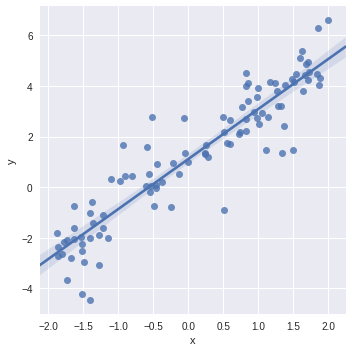

In [109]:
sns.lmplot(x='x', y='y', data=df3)

In [110]:
def grid_search(df, steps=10, a_min=-1, a_max=1, b_min=-1, b_max=1):
    best_error, best_a, best_b = inf, None, None
    for a in np.linspace(a_min, a_max, num=steps):
        for b in np.linspace(b_min, b_max, num=steps):
            error = evaluate(a, b, df)
            if error < best_error:
                best_error, best_a, best_b = error, a, b
    return best_a, best_b, best_error

def evaluate(a, b, df):
    sqerror = ([error(a, b, point) for point in df.itertuples()])
    rmse = sqrt(np.mean(sqerror))
    return rmse

def error(a, b, point):
    py = a * point.x + b
    return (point.y - py) ** 2

def print_results(a, b, error):
    print('y = {a:.2f}x + {b:.2f} ---> rmse={e:.2f}'
          .format(a=a, b=b, e=error))

abe = grid_search(df3, a_min=1, a_max=5, b_min=0, b_max=2, steps=30)
print_results(*abe)

y = 1.97x + 1.10 ---> rmse=1.01


In [128]:
def analytic_solution(df):
    n, x, y = len(df), df.x, df.y
    a = ((n * sum(x*y) - sum(x)*sum(y))
         / (n * sum(x**2) - sum(x)**2))
    b = np.mean(y) - a * np.mean(x)
    return a, b

analytic_solution(df3)

(1.9770775223263193, 1.1185524504716633)

### Provided Linear Data

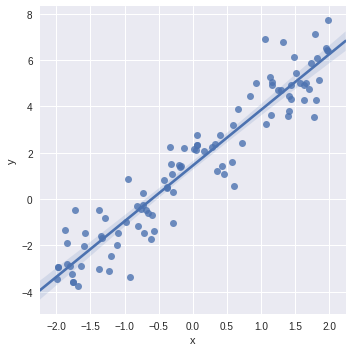

In [32]:
sns.lmplot(x='x', y='y', data=df1)

In [105]:
abe = grid_search(df1, a_min=1, a_max=5, b_min=0, b_max=2, steps=30)
print_results(*abe)

y = 2.38x + 1.45 ---> rmse=1.01


### Old Faithful

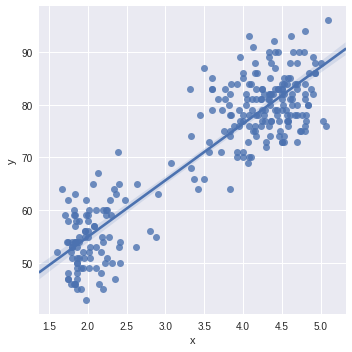

In [73]:
sns.lmplot(x='x', y='y', data=df2)

In [80]:
abe = grid_search(df2, a_min=5, a_max=20, b_min=20, b_max=40, steps=30)
print_results(*abe)

y = 10.69x + 33.79 ---> rmse=5.90


-----

# B) Clusters Detections